In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_TSNE3_TSNE2.pth'


/home/guangwei/miniconda3/envs/sit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
from sklearn.manifold import TSNE
def extract_hidden_states(texts, model, tokenizer, apply_tsne=True, n_components=3, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_state = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
        hidden_states.append(hidden_state)

    hidden_states = np.vstack(hidden_states)
    if apply_tsne:
        tsne = TSNE(n_components=n_components, random_state=42)
        hidden_states = tsne.fit_transform(hidden_states)
        print(f"Hidden states reduced to {n_components} dimensions using t-SNE.")
        
    return hidden_states

def extract_reference_embeddings(references, model, tokenizer, apply_tsne=True, n_components=2, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())  # 提取池化后的输出

    embeddings = np.vstack(embeddings)
    
    # 应用 t-SNE
    if apply_tsne:
        tsne = TSNE(n_components=n_components, random_state=42)
        embeddings = tsne.fit_transform(embeddings)
        print(f"Reference embeddings reduced to {n_components} dimensions using t-SNE.")
    
    return embeddings

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]
/home/guangwei/miniconda3/envs/sit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 373/373 [01:43<00:00,  3.59it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Hidden states reduced to 3 dimensions using t-SNE.
Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 373/373 [00:04<00:00, 91.25it/s] 


Reference embeddings reduced to 2 dimensions using t-SNE.
Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 354/354 [01:52<00:00,  3.15it/s]


Hidden states reduced to 3 dimensions using t-SNE.
Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 354/354 [00:03<00:00, 104.96it/s]


Reference embeddings reduced to 2 dimensions using t-SNE.


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=5 and hidden_dim=256


Training Epochs:   0%|          | 7/2000 [00:00<00:30, 64.65it/s]

Epoch 10/2000, Loss: 18.1875
Test Accuracy at Epoch 10: 55.42%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.63      0.21      0.31       283
non_infringement       0.54      0.88      0.67       298

        accuracy                           0.55       581
       macro avg       0.58      0.55      0.49       581
    weighted avg       0.58      0.55      0.50       581

New best model saved with accuracy 55.42% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.63      0.21      0.31       283
non_infringement       0.54      0.88      0.67       298

        accuracy                           0.55       581
       macro avg       0.58      0.55      0.49       581
    weighted avg       0.58      0.55      0.50       581



Training Epochs:   1%|          | 17/2000 [00:00<00:23, 84.23it/s]

Epoch 20/2000, Loss: 7.5544
Test Accuracy at Epoch 20: 52.84%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.53      0.30      0.38       283
non_infringement       0.53      0.74      0.62       298

        accuracy                           0.53       581
       macro avg       0.53      0.52      0.50       581
    weighted avg       0.53      0.53      0.50       581



Training Epochs:   2%|▏         | 39/2000 [00:00<00:20, 95.69it/s]

Epoch 30/2000, Loss: 4.4112
Test Accuracy at Epoch 30: 50.26%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.49      0.53      0.51       283
non_infringement       0.52      0.48      0.50       298

        accuracy                           0.50       581
       macro avg       0.50      0.50      0.50       581
    weighted avg       0.50      0.50      0.50       581

Epoch 40/2000, Loss: 2.9763
Test Accuracy at Epoch 40: 50.95%


Training Epochs:   2%|▎         | 50/2000 [00:00<00:19, 99.46it/s]

Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.50      0.46      0.48       283
non_infringement       0.52      0.56      0.54       298

        accuracy                           0.51       581
       macro avg       0.51      0.51      0.51       581
    weighted avg       0.51      0.51      0.51       581

Epoch 50/2000, Loss: 2.3244
Test Accuracy at Epoch 50: 49.05%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.48      0.51      0.49       283
non_infringement       0.50      0.47      0.49       298

        accuracy                           0.49       581
       macro avg       0.49      0.49      0.49       581
    weighted avg       0.49      0.49      0.49       581



Training Epochs:   3%|▎         | 62/2000 [00:00<00:18, 104.86it/s]

Epoch 60/2000, Loss: 1.7426
Test Accuracy at Epoch 60: 53.18%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.52      0.44      0.48       283
non_infringement       0.54      0.62      0.57       298

        accuracy                           0.53       581
       macro avg       0.53      0.53      0.53       581
    weighted avg       0.53      0.53      0.53       581



Training Epochs:   4%|▎         | 73/2000 [00:00<00:20, 95.60it/s] 

Epoch 70/2000, Loss: 1.3277
Test Accuracy at Epoch 70: 50.26%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.49      0.46      0.47       283
non_infringement       0.51      0.54      0.53       298

        accuracy                           0.50       581
       macro avg       0.50      0.50      0.50       581
    weighted avg       0.50      0.50      0.50       581



Training Epochs:   4%|▍         | 85/2000 [00:00<00:18, 101.91it/s]

Epoch 80/2000, Loss: 1.0634
Test Accuracy at Epoch 80: 57.14%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.57      0.51      0.54       283
non_infringement       0.58      0.63      0.60       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581

New best model saved with accuracy 57.14% at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.57      0.51      0.54       283
non_infringement       0.58      0.63      0.60       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581

Epoch 90/2000, Loss: 0.8874
Test Accuracy at Epoch 90: 57.49%
Classification Report at Epoch 90:
          

Training Epochs:   5%|▍         | 98/2000 [00:00<00:17, 108.49it/s]

Epoch 100/2000, Loss: 0.7569
Test Accuracy at Epoch 100: 56.97%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.57      0.49      0.52       283
non_infringement       0.57      0.65      0.61       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581



Training Epochs:   6%|▌         | 110/2000 [00:01<00:19, 96.71it/s]

Epoch 110/2000, Loss: 0.6644
Test Accuracy at Epoch 110: 58.00%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.58      0.51      0.54       283
non_infringement       0.58      0.64      0.61       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

New best model saved with accuracy 58.00% at epoch 110
Best Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.58      0.51      0.54       283
non_infringement       0.58      0.64      0.61       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

Epoch 120/2000, Loss: 0.5923
Test Accuracy at Epoch 120: 58.69%


Training Epochs:   7%|▋         | 131/2000 [00:01<00:25, 74.42it/s]

Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.59      0.52      0.55       283
non_infringement       0.59      0.65      0.62       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581

New best model saved with accuracy 58.69% at epoch 120
Best Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.59      0.52      0.55       283
non_infringement       0.59      0.65      0.62       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.58       581
    weighted avg       0.59      0.59      0.58       581

Epoch 130/2000, Loss: 0.5355
Test Accuracy at Epoch 130: 57.83%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    inf

Training Epochs:   8%|▊         | 154/2000 [00:01<00:20, 91.14it/s]

Epoch 140/2000, Loss: 0.4894
Test Accuracy at Epoch 140: 58.00%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.58      0.51      0.54       283
non_infringement       0.58      0.65      0.61       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

Epoch 150/2000, Loss: 0.5913
Test Accuracy at Epoch 150: 57.31%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.57      0.50      0.53       283
non_infringement       0.58      0.64      0.61       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581

Epoch 160/2000, Loss: 0.4778
Test Accuracy at Epoch 160: 57.14%
Classification Report at Epoch 160

Training Epochs:   9%|▉         | 188/2000 [00:02<00:19, 93.56it/s]

Epoch 170/2000, Loss: 0.4248
Test Accuracy at Epoch 170: 58.00%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.58      0.51      0.54       283
non_infringement       0.58      0.64      0.61       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

Epoch 180/2000, Loss: 0.3742
Test Accuracy at Epoch 180: 57.14%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.57      0.49      0.53       283
non_infringement       0.57      0.65      0.61       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581



Training Epochs:  10%|▉         | 199/2000 [00:02<00:18, 97.57it/s]

Epoch 190/2000, Loss: 0.3488
Test Accuracy at Epoch 190: 56.80%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.57      0.49      0.52       283
non_infringement       0.57      0.64      0.60       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.56       581
    weighted avg       0.57      0.57      0.57       581

Epoch 200/2000, Loss: 0.3265
Test Accuracy at Epoch 200: 56.97%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.57      0.50      0.53       283
non_infringement       0.57      0.63      0.60       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581



Training Epochs:  11%|█         | 222/2000 [00:02<00:18, 95.02it/s]

Epoch 210/2000, Loss: 0.3073
Test Accuracy at Epoch 210: 56.63%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.56      0.49      0.52       283
non_infringement       0.57      0.64      0.60       298

        accuracy                           0.57       581
       macro avg       0.57      0.56      0.56       581
    weighted avg       0.57      0.57      0.56       581

Epoch 220/2000, Loss: 0.2899
Test Accuracy at Epoch 220: 55.94%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.56      0.48      0.51       283
non_infringement       0.56      0.64      0.60       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581

Epoch 230/2000, Loss: 0.2791
Test Accuracy at Epoch 230: 54.91%
Classification Report at Epoch 230

Training Epochs:  13%|█▎        | 257/2000 [00:02<00:18, 95.79it/s] 

Epoch 240/2000, Loss: 0.3677
Test Accuracy at Epoch 240: 54.91%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.54      0.51      0.52       283
non_infringement       0.56      0.59      0.57       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581

Epoch 250/2000, Loss: 0.9296
Test Accuracy at Epoch 250: 58.69%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.60      0.45      0.51       283
non_infringement       0.58      0.72      0.64       298

        accuracy                           0.59       581
       macro avg       0.59      0.58      0.58       581
    weighted avg       0.59      0.59      0.58       581



Training Epochs:  14%|█▍        | 281/2000 [00:02<00:16, 103.25it/s]

Epoch 260/2000, Loss: 0.4420
Test Accuracy at Epoch 260: 58.00%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.60      0.43      0.50       283
non_infringement       0.57      0.72      0.64       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.57       581
    weighted avg       0.58      0.58      0.57       581

Epoch 270/2000, Loss: 0.3516
Test Accuracy at Epoch 270: 56.45%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.57      0.43      0.49       283
non_infringement       0.56      0.69      0.62       298

        accuracy                           0.56       581
       macro avg       0.57      0.56      0.56       581
    weighted avg       0.57      0.56      0.56       581

Epoch 280/2000, Loss: 0.2738
Test Accuracy at Epoch 280: 58.00%
Classification Report at Epoch 280

Training Epochs:  15%|█▌        | 303/2000 [00:03<00:18, 92.11it/s] 

Epoch 290/2000, Loss: 0.2486
Test Accuracy at Epoch 290: 56.11%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.56      0.46      0.51       283
non_infringement       0.56      0.65      0.60       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581

Epoch 300/2000, Loss: 0.2145
Test Accuracy at Epoch 300: 57.49%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.58      0.48      0.52       283
non_infringement       0.57      0.66      0.62       298

        accuracy                           0.57       581
       macro avg       0.58      0.57      0.57       581
    weighted avg       0.58      0.57      0.57       581



Training Epochs:  16%|█▌        | 324/2000 [00:03<00:19, 86.82it/s]

Epoch 310/2000, Loss: 0.1980
Test Accuracy at Epoch 310: 56.97%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.57      0.51      0.53       283
non_infringement       0.57      0.63      0.60       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581

Epoch 320/2000, Loss: 0.1876
Test Accuracy at Epoch 320: 56.97%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.56      0.51      0.54       283
non_infringement       0.57      0.63      0.60       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581



Training Epochs:  17%|█▋        | 347/2000 [00:03<00:16, 97.95it/s]

Epoch 330/2000, Loss: 0.1791
Test Accuracy at Epoch 330: 57.14%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.57      0.51      0.53       283
non_infringement       0.57      0.63      0.60       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581

Epoch 340/2000, Loss: 0.1722
Test Accuracy at Epoch 340: 56.80%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.56      0.50      0.53       283
non_infringement       0.57      0.63      0.60       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581

Epoch 350/2000, Loss: 0.1662
Test Accuracy at Epoch 350: 56.45%
Classification Report at Epoch 350

Training Epochs:  18%|█▊        | 370/2000 [00:03<00:17, 93.48it/s] 

Epoch 360/2000, Loss: 0.1606
Test Accuracy at Epoch 360: 56.80%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.56      0.50      0.53       283
non_infringement       0.57      0.63      0.60       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581

Epoch 370/2000, Loss: 0.1555
Test Accuracy at Epoch 370: 57.49%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.57      0.51      0.54       283
non_infringement       0.58      0.64      0.61       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581

Epoch 380/2000, Loss: 0.1508
Test Accuracy at Epoch 380: 58.00%
Classification Report at Epoch 380

Training Epochs:  20%|██        | 404/2000 [00:04<00:17, 90.67it/s] 

Epoch 390/2000, Loss: 0.1464
Test Accuracy at Epoch 390: 58.00%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.58      0.52      0.54       283
non_infringement       0.58      0.64      0.61       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

Epoch 400/2000, Loss: 0.1423
Test Accuracy at Epoch 400: 59.04%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.59      0.53      0.56       283
non_infringement       0.59      0.65      0.62       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

New best model saved with accuracy 59.04% at epoch 400
Best Classification Report at Epoch 400:
  

Training Epochs:  21%|██▏       | 428/2000 [00:04<00:15, 102.32it/s]

Epoch 410/2000, Loss: 0.1384
Test Accuracy at Epoch 410: 59.04%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.59      0.53      0.56       283
non_infringement       0.59      0.65      0.62       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 420/2000, Loss: 0.1347
Test Accuracy at Epoch 420: 58.86%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.59      0.53      0.56       283
non_infringement       0.59      0.64      0.62       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 430/2000, Loss: 0.1312
Test Accuracy at Epoch 430: 58.52%
Classification Report at Epoch 430

Training Epochs:  23%|██▎       | 462/2000 [00:04<00:15, 99.44it/s] 

Epoch 440/2000, Loss: 0.1279
Test Accuracy at Epoch 440: 58.35%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.58      0.53      0.55       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

Epoch 450/2000, Loss: 0.1247
Test Accuracy at Epoch 450: 58.35%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.58      0.53      0.55       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

Epoch 460/2000, Loss: 0.1216
Test Accuracy at Epoch 460: 58.18%
Classification Report at Epoch 460

Training Epochs:  24%|██▍       | 486/2000 [00:05<00:15, 99.69it/s] 

Epoch 470/2000, Loss: 0.1187
Test Accuracy at Epoch 470: 58.18%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.58      0.53      0.55       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

Epoch 480/2000, Loss: 0.1158
Test Accuracy at Epoch 480: 58.52%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.58      0.53      0.55       283
non_infringement       0.59      0.64      0.61       298

        accuracy                           0.59       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.59      0.58       581



Training Epochs:  25%|██▌       | 509/2000 [00:05<00:14, 105.22it/s]

Epoch 490/2000, Loss: 0.1131
Test Accuracy at Epoch 490: 58.52%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.58      0.53      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.59      0.58       581

Epoch 500/2000, Loss: 0.1105
Test Accuracy at Epoch 500: 58.86%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.64      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 510/2000, Loss: 0.1080
Test Accuracy at Epoch 510: 58.69%
Classification Report at Epoch 510

Training Epochs:  27%|██▋       | 532/2000 [00:05<00:15, 96.50it/s] 

Epoch 520/2000, Loss: 0.1055
Test Accuracy at Epoch 520: 58.86%
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.64      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 530/2000, Loss: 0.1032
Test Accuracy at Epoch 530: 59.04%
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.56       283
non_infringement       0.59      0.64      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  28%|██▊       | 555/2000 [00:05<00:13, 103.48it/s]

Epoch 540/2000, Loss: 0.1009
Test Accuracy at Epoch 540: 59.90%
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

New best model saved with accuracy 59.90% at epoch 540
Best Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 550/2000, Loss: 0.0986
Test Accuracy at Epoch 550: 60.07%
Classification Report at Epoch 550:
  

Training Epochs:  29%|██▉       | 577/2000 [00:06<00:15, 92.28it/s] 

Epoch 560/2000, Loss: 0.0965
Test Accuracy at Epoch 560: 60.24%
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.61      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

New best model saved with accuracy 60.24% at epoch 560
Best Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.61      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 570/2000, Loss: 0.0944
Test Accuracy at Epoch 570: 60.24%
Classification Report at Epoch 570:
  

Training Epochs:  29%|██▉       | 589/2000 [00:06<00:14, 98.00it/s]

Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.60      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 590/2000, Loss: 0.0903
Test Accuracy at Epoch 590: 59.90%
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581



Training Epochs:  31%|███       | 611/2000 [00:06<00:15, 90.30it/s]

Epoch 600/2000, Loss: 0.0884
Test Accuracy at Epoch 600: 59.72%
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 610/2000, Loss: 0.0865
Test Accuracy at Epoch 610: 59.72%
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

Epoch 620/2000, Loss: 0.0847
Test Accuracy at Epoch 620: 59.38%
Classification Report at Epoch 620

Training Epochs:  32%|███▏      | 642/2000 [00:06<00:15, 89.03it/s]

Epoch 630/2000, Loss: 0.0829
Test Accuracy at Epoch 630: 59.21%
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 640/2000, Loss: 0.0812
Test Accuracy at Epoch 640: 59.21%
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  33%|███▎      | 666/2000 [00:07<00:13, 102.21it/s]

Epoch 650/2000, Loss: 0.0795
Test Accuracy at Epoch 650: 59.04%
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.56       283
non_infringement       0.59      0.64      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 660/2000, Loss: 0.0779
Test Accuracy at Epoch 660: 59.21%
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  34%|███▍      | 689/2000 [00:07<00:12, 101.83it/s]

Epoch 670/2000, Loss: 0.0763
Test Accuracy at Epoch 670: 59.38%
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 680/2000, Loss: 0.0748
Test Accuracy at Epoch 680: 59.38%
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 690/2000, Loss: 0.0733
Test Accuracy at Epoch 690: 59.55%
Classification Report at Epoch 690

Training Epochs:  36%|███▌      | 711/2000 [00:07<00:15, 85.39it/s] 

Epoch 700/2000, Loss: 0.0719
Test Accuracy at Epoch 700: 59.21%
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 710/2000, Loss: 0.0705
Test Accuracy at Epoch 710: 59.21%
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.57       283
non_infringement       0.60      0.64      0.62       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  37%|███▋      | 737/2000 [00:07<00:12, 102.24it/s]

Epoch 720/2000, Loss: 0.0691
Test Accuracy at Epoch 720: 59.04%
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.59      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 730/2000, Loss: 0.0678
Test Accuracy at Epoch 730: 59.21%
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 740/2000, Loss: 0.0665
Test Accuracy at Epoch 740: 59.21%
Classification Report at Epoch 740

Training Epochs:  38%|███▊      | 770/2000 [00:08<00:12, 99.34it/s] 

Epoch 750/2000, Loss: 0.0652
Test Accuracy at Epoch 750: 59.21%
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 760/2000, Loss: 0.0640
Test Accuracy at Epoch 760: 59.04%
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 770/2000, Loss: 0.0628
Test Accuracy at Epoch 770: 59.04%
Classification Report at Epoch 770

Training Epochs:  40%|███▉      | 794/2000 [00:08<00:12, 97.25it/s] 

Epoch 780/2000, Loss: 0.0617
Test Accuracy at Epoch 780: 59.04%
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 790/2000, Loss: 0.0606
Test Accuracy at Epoch 790: 59.04%
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  41%|████      | 817/2000 [00:08<00:11, 104.19it/s]

Epoch 800/2000, Loss: 0.0595
Test Accuracy at Epoch 800: 58.86%
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 810/2000, Loss: 0.0584
Test Accuracy at Epoch 810: 58.69%
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 820/2000, Loss: 0.0574
Test Accuracy at Epoch 820: 58.69%
Classification Report at Epoch 820

Training Epochs:  42%|████▏     | 840/2000 [00:08<00:11, 99.13it/s] 

Epoch 830/2000, Loss: 0.0564
Test Accuracy at Epoch 830: 58.69%
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 840/2000, Loss: 0.0554
Test Accuracy at Epoch 840: 58.52%
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.59      0.58       581

Epoch 850/2000, Loss: 0.0545
Test Accuracy at Epoch 850: 58.52%
Classification Report at Epoch 850

Training Epochs:  44%|████▎     | 874/2000 [00:09<00:11, 97.80it/s] 

Epoch 860/2000, Loss: 0.0535
Test Accuracy at Epoch 860: 58.35%
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581

Epoch 870/2000, Loss: 0.0526
Test Accuracy at Epoch 870: 58.35%
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.58       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.58      0.58       581



Training Epochs:  45%|████▌     | 900/2000 [00:09<00:10, 109.81it/s]

Epoch 880/2000, Loss: 0.0518
Test Accuracy at Epoch 880: 58.52%
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.59      0.58       581

Epoch 890/2000, Loss: 0.0509
Test Accuracy at Epoch 890: 58.52%
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.58      0.58      0.58       581
    weighted avg       0.58      0.59      0.58       581

Epoch 900/2000, Loss: 0.0501
Test Accuracy at Epoch 900: 58.52%
Classification Report at Epoch 900

Training Epochs:  46%|████▋     | 926/2000 [00:09<00:09, 110.68it/s]

Epoch 910/2000, Loss: 0.0493
Test Accuracy at Epoch 910: 58.69%
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 920/2000, Loss: 0.0485
Test Accuracy at Epoch 920: 58.69%
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  48%|████▊     | 953/2000 [00:09<00:08, 117.66it/s]

Epoch 930/2000, Loss: 0.0477
Test Accuracy at Epoch 930: 58.69%
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 940/2000, Loss: 0.0470
Test Accuracy at Epoch 940: 58.69%
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 950/2000, Loss: 0.0463
Test Accuracy at Epoch 950: 58.69%
Classification Report at Epoch 950

Training Epochs:  49%|████▉     | 979/2000 [00:10<00:09, 109.94it/s]

Epoch 960/2000, Loss: 0.0455
Test Accuracy at Epoch 960: 58.86%
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 970/2000, Loss: 0.0448
Test Accuracy at Epoch 970: 58.86%
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 980/2000, Loss: 0.0442
Test Accuracy at Epoch 980: 58.86%
Classification Report at Epoch 980

Training Epochs:  50%|█████     | 1003/2000 [00:10<00:09, 100.70it/s]

Epoch 990/2000, Loss: 0.0435
Test Accuracy at Epoch 990: 58.86%
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1000/2000, Loss: 0.0429
Test Accuracy at Epoch 1000: 59.21%
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  51%|█████▏    | 1028/2000 [00:10<00:08, 109.00it/s]

Epoch 1010/2000, Loss: 0.0422
Test Accuracy at Epoch 1010: 58.86%
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1020/2000, Loss: 0.0416
Test Accuracy at Epoch 1020: 58.86%
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1030/2000, Loss: 0.0410
Test Accuracy at Epoch 1030: 58.86%
Classification Report at E

Training Epochs:  53%|█████▎    | 1052/2000 [00:10<00:09, 102.76it/s]

Epoch 1040/2000, Loss: 0.0404
Test Accuracy at Epoch 1040: 58.86%
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1050/2000, Loss: 0.0398
Test Accuracy at Epoch 1050: 58.86%
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.58      0.54      0.56       283
non_infringement       0.59      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1060/2000, Loss: 0.0393
Test Accuracy at Epoch 1060: 58.69%
Classification Report at E

Training Epochs:  54%|█████▍    | 1085/2000 [00:11<00:09, 92.78it/s] 

Epoch 1070/2000, Loss: 0.0387
Test Accuracy at Epoch 1070: 58.69%
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.56       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1080/2000, Loss: 0.0382
Test Accuracy at Epoch 1080: 58.69%
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.56       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  55%|█████▌    | 1109/2000 [00:11<00:08, 102.93it/s]

Epoch 1090/2000, Loss: 0.0376
Test Accuracy at Epoch 1090: 58.69%
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.56       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1100/2000, Loss: 0.0371
Test Accuracy at Epoch 1100: 58.69%
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.56       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1110/2000, Loss: 0.0366
Test Accuracy at Epoch 1110: 58.69%
Classification Report at E

Training Epochs:  57%|█████▋    | 1133/2000 [00:11<00:08, 100.04it/s]

Epoch 1120/2000, Loss: 0.0361
Test Accuracy at Epoch 1120: 58.86%
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1130/2000, Loss: 0.0356
Test Accuracy at Epoch 1130: 58.86%
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1140/2000, Loss: 0.0351
Test Accuracy at Epoch 1140: 58.86%
Classification Report at E

Training Epochs:  58%|█████▊    | 1159/2000 [00:11<00:07, 113.63it/s]

Epoch 1150/2000, Loss: 0.0347
Test Accuracy at Epoch 1150: 58.86%
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1160/2000, Loss: 0.0342
Test Accuracy at Epoch 1160: 58.86%
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  59%|█████▉    | 1183/2000 [00:12<00:08, 101.61it/s]

Epoch 1170/2000, Loss: 0.0337
Test Accuracy at Epoch 1170: 58.86%
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1180/2000, Loss: 0.0333
Test Accuracy at Epoch 1180: 59.04%
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1190/2000, Loss: 0.0329
Test Accuracy at Epoch 1190: 59.21%
Classification Report at E

Training Epochs:  61%|██████    | 1220/2000 [00:12<00:07, 100.48it/s]

Epoch 1200/2000, Loss: 0.0324
Test Accuracy at Epoch 1200: 59.21%
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1210/2000, Loss: 0.0320
Test Accuracy at Epoch 1210: 59.21%
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.59      0.55      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1220/2000, Loss: 0.0316
Test Accuracy at Epoch 1220: 59.21%
Classification Report at E

Training Epochs:  62%|██████▏   | 1243/2000 [00:12<00:08, 94.17it/s] 

Epoch 1230/2000, Loss: 0.0312
Test Accuracy at Epoch 1230: 59.04%
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1240/2000, Loss: 0.0308
Test Accuracy at Epoch 1240: 59.04%
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  63%|██████▎   | 1265/2000 [00:12<00:07, 98.86it/s]

Epoch 1250/2000, Loss: 0.0304
Test Accuracy at Epoch 1250: 59.04%
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1260/2000, Loss: 0.0300
Test Accuracy at Epoch 1260: 59.04%
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1270/2000, Loss: 0.0296
Test Accuracy at Epoch 1270: 59.04%
Classification Report at E

Training Epochs:  65%|██████▌   | 1300/2000 [00:13<00:07, 99.66it/s] 

Epoch 1280/2000, Loss: 0.0292
Test Accuracy at Epoch 1280: 59.04%
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1290/2000, Loss: 0.0289
Test Accuracy at Epoch 1290: 58.69%
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1300/2000, Loss: 0.0285
Test Accuracy at Epoch 1300: 58.69%
Classification Report at E

Training Epochs:  66%|██████▌   | 1322/2000 [00:13<00:07, 92.88it/s] 

Epoch 1310/2000, Loss: 0.0282
Test Accuracy at Epoch 1310: 58.69%
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1320/2000, Loss: 0.0278
Test Accuracy at Epoch 1320: 58.86%
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  67%|██████▋   | 1348/2000 [00:13<00:05, 109.49it/s]

Epoch 1330/2000, Loss: 0.0275
Test Accuracy at Epoch 1330: 58.86%
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1340/2000, Loss: 0.0271
Test Accuracy at Epoch 1340: 58.86%
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1350/2000, Loss: 0.0268
Test Accuracy at Epoch 1350: 59.04%
Classification Report at E

Training Epochs:  69%|██████▊   | 1372/2000 [00:13<00:06, 100.43it/s]

Epoch 1360/2000, Loss: 0.0265
Test Accuracy at Epoch 1360: 59.21%
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1370/2000, Loss: 0.0261
Test Accuracy at Epoch 1370: 59.21%
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  70%|██████▉   | 1397/2000 [00:14<00:05, 109.89it/s]

Epoch 1380/2000, Loss: 0.0258
Test Accuracy at Epoch 1380: 59.21%
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1390/2000, Loss: 0.0255
Test Accuracy at Epoch 1390: 59.21%
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1400/2000, Loss: 0.0252
Test Accuracy at Epoch 1400: 59.21%
Classification Report at E

Training Epochs:  71%|███████   | 1421/2000 [00:14<00:05, 104.69it/s]

Epoch 1410/2000, Loss: 0.0249
Test Accuracy at Epoch 1410: 59.21%
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1420/2000, Loss: 0.0246
Test Accuracy at Epoch 1420: 59.21%
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1430/2000, Loss: 0.0243
Test Accuracy at Epoch 1430: 59.21%
Classification Report at E

Training Epochs:  72%|███████▏  | 1446/2000 [00:14<00:05, 94.87it/s] 

Epoch 1440/2000, Loss: 0.0240
Test Accuracy at Epoch 1440: 59.21%
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1450/2000, Loss: 0.0237
Test Accuracy at Epoch 1450: 59.21%
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  74%|███████▍  | 1480/2000 [00:15<00:04, 104.41it/s]

Epoch 1460/2000, Loss: 0.0235
Test Accuracy at Epoch 1460: 59.21%
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1470/2000, Loss: 0.0232
Test Accuracy at Epoch 1470: 59.21%
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1480/2000, Loss: 0.0229
Test Accuracy at Epoch 1480: 59.21%
Classification Report at E

Training Epochs:  75%|███████▌  | 1503/2000 [00:15<00:04, 100.40it/s]

Epoch 1490/2000, Loss: 0.0227
Test Accuracy at Epoch 1490: 59.04%
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1500/2000, Loss: 0.0224
Test Accuracy at Epoch 1500: 59.04%
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1510/2000, Loss: 0.0221
Test Accuracy at Epoch 1510: 59.04%
Classification Report at E

Training Epochs:  76%|███████▋  | 1526/2000 [00:15<00:04, 96.61it/s] 

Epoch 1520/2000, Loss: 0.0219
Test Accuracy at Epoch 1520: 59.04%
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1530/2000, Loss: 0.0216
Test Accuracy at Epoch 1530: 59.04%
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  78%|███████▊  | 1560/2000 [00:15<00:04, 102.05it/s]

Epoch 1540/2000, Loss: 0.0214
Test Accuracy at Epoch 1540: 59.04%
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1550/2000, Loss: 0.0211
Test Accuracy at Epoch 1550: 59.04%
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1560/2000, Loss: 0.0209
Test Accuracy at Epoch 1560: 59.04%
Classification Report at E

Training Epochs:  79%|███████▉  | 1585/2000 [00:16<00:04, 102.45it/s]

Epoch 1570/2000, Loss: 0.0207
Test Accuracy at Epoch 1570: 59.21%
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.58      0.57      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1580/2000, Loss: 0.0204
Test Accuracy at Epoch 1580: 59.21%
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.58      0.57      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1590/2000, Loss: 0.0202
Test Accuracy at Epoch 1590: 59.21%
Classification Report at E

Training Epochs:  81%|████████  | 1611/2000 [00:16<00:03, 99.83it/s] 

Epoch 1600/2000, Loss: 0.0200
Test Accuracy at Epoch 1600: 59.04%
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1610/2000, Loss: 0.0197
Test Accuracy at Epoch 1610: 59.04%
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  82%|████████▏ | 1636/2000 [00:16<00:03, 108.09it/s]

Epoch 1620/2000, Loss: 0.0195
Test Accuracy at Epoch 1620: 59.21%
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1630/2000, Loss: 0.0193
Test Accuracy at Epoch 1630: 59.21%
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1640/2000, Loss: 0.0191
Test Accuracy at Epoch 1640: 59.21%
Classification Report at E

Training Epochs:  83%|████████▎ | 1660/2000 [00:16<00:03, 101.46it/s]

Epoch 1650/2000, Loss: 0.0189
Test Accuracy at Epoch 1650: 59.21%
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1660/2000, Loss: 0.0187
Test Accuracy at Epoch 1660: 59.21%
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1670/2000, Loss: 0.0185
Test Accuracy at Epoch 1670: 59.21%
Classification Report at E

Training Epochs:  85%|████████▍ | 1694/2000 [00:17<00:03, 94.09it/s] 

Epoch 1680/2000, Loss: 0.0183
Test Accuracy at Epoch 1680: 59.21%
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1690/2000, Loss: 0.0181
Test Accuracy at Epoch 1690: 59.21%
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  86%|████████▌ | 1718/2000 [00:17<00:02, 103.61it/s]

Epoch 1700/2000, Loss: 0.0179
Test Accuracy at Epoch 1700: 59.21%
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.58      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1710/2000, Loss: 0.0177
Test Accuracy at Epoch 1710: 59.38%
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1720/2000, Loss: 0.0175
Test Accuracy at Epoch 1720: 59.38%
Classification Report at E

Training Epochs:  88%|████████▊ | 1753/2000 [00:17<00:02, 105.95it/s]

Epoch 1730/2000, Loss: 0.0173
Test Accuracy at Epoch 1730: 59.55%
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.58       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.60       581
       macro avg       0.60      0.59      0.59       581
    weighted avg       0.60      0.60      0.60       581

Epoch 1740/2000, Loss: 0.0171
Test Accuracy at Epoch 1740: 59.38%
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1750/2000, Loss: 0.0169
Test Accuracy at Epoch 1750: 59.38%
Classification Report at E

Training Epochs:  88%|████████▊ | 1765/2000 [00:17<00:02, 107.99it/s]

Epoch 1760/2000, Loss: 0.0168
Test Accuracy at Epoch 1760: 59.38%
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1770/2000, Loss: 0.0166
Test Accuracy at Epoch 1770: 59.38%
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  90%|████████▉ | 1797/2000 [00:18<00:02, 95.99it/s] 

Epoch 1780/2000, Loss: 0.0164
Test Accuracy at Epoch 1780: 59.38%
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.63      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1790/2000, Loss: 0.0162
Test Accuracy at Epoch 1790: 59.21%
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  90%|█████████ | 1807/2000 [00:18<00:02, 84.10it/s]

Epoch 1800/2000, Loss: 0.0161
Test Accuracy at Epoch 1800: 59.21%
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1810/2000, Loss: 0.0159
Test Accuracy at Epoch 1810: 59.21%
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  92%|█████████▏| 1833/2000 [00:18<00:01, 100.19it/s]

Epoch 1820/2000, Loss: 0.0157
Test Accuracy at Epoch 1820: 59.21%
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1830/2000, Loss: 0.0156
Test Accuracy at Epoch 1830: 59.21%
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1840/2000, Loss: 0.0154
Test Accuracy at Epoch 1840: 59.21%
Classification Report at E

Training Epochs:  93%|█████████▎| 1866/2000 [00:18<00:01, 100.63it/s]

Epoch 1850/2000, Loss: 0.0153
Test Accuracy at Epoch 1850: 59.21%
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.59      0.56      0.57       283
non_infringement       0.60      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1860/2000, Loss: 0.0151
Test Accuracy at Epoch 1860: 58.86%
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1870/2000, Loss: 0.0149
Test Accuracy at Epoch 1870: 58.86%
Classification Report at E

Training Epochs:  94%|█████████▍| 1889/2000 [00:19<00:01, 95.64it/s] 

Epoch 1880/2000, Loss: 0.0148
Test Accuracy at Epoch 1880: 58.86%
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1890/2000, Loss: 0.0146
Test Accuracy at Epoch 1890: 58.86%
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581



Training Epochs:  96%|█████████▌| 1913/2000 [00:19<00:00, 105.16it/s]

Epoch 1900/2000, Loss: 0.0145
Test Accuracy at Epoch 1900: 58.86%
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1910/2000, Loss: 0.0143
Test Accuracy at Epoch 1910: 58.86%
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.57       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1920/2000, Loss: 0.0142
Test Accuracy at Epoch 1920: 58.86%
Classification Report at E

Training Epochs:  98%|█████████▊| 1950/2000 [00:19<00:00, 109.63it/s]

Epoch 1930/2000, Loss: 0.0141
Test Accuracy at Epoch 1930: 58.69%
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.56       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1940/2000, Loss: 0.0139
Test Accuracy at Epoch 1940: 58.69%
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.56       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1950/2000, Loss: 0.0138
Test Accuracy at Epoch 1950: 58.69%
Classification Report at E

Training Epochs:  99%|█████████▉| 1975/2000 [00:19<00:00, 106.36it/s]

Epoch 1960/2000, Loss: 0.0136
Test Accuracy at Epoch 1960: 58.69%
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.56       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1970/2000, Loss: 0.0135
Test Accuracy at Epoch 1970: 58.69%
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.56       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1980/2000, Loss: 0.0134


Training Epochs: 100%|██████████| 2000/2000 [00:20<00:00, 99.26it/s] 

Test Accuracy at Epoch 1980: 58.69%
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.56       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 1990/2000, Loss: 0.0132
Test Accuracy at Epoch 1990: 58.69%
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.58      0.55      0.56       283
non_infringement       0.59      0.62      0.61       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 2000/2000, Loss: 0.0131
Test Accuracy at Epoch 2000: 58.69%
Classification Report at Epoch 2000:
                  p


/tmp/ipykernel_2420859/85556528.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


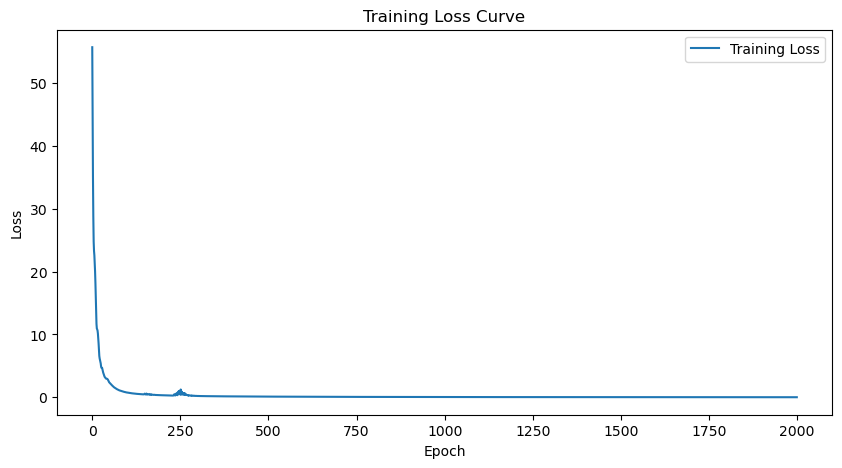

Final Model Accuracy: 60.24%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token_TSNE3_TSNE2.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

/tmp/ipykernel_2420859/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


                  precision    recall  f1-score   support

    infringement       0.60      0.56      0.58       283
non_infringement       0.61      0.64      0.62       298

        accuracy                           0.60       581
       macro avg       0.60      0.60      0.60       581
    weighted avg       0.60      0.60      0.60       581

